# Training Neural Networks with Noisy Labels

Neural networks, especially deep neural networks with many parameters, require a large amount of training data. This has led to the development of sophisticated data augmentation methods as well as entire industries dedicated to data annotation. The validation of these annotation labels is a common problem whenever such a large amount of data is involved as incorrect, or noisy, labels can lead to incorrectly trained machine learning algorithms that do not properly identify patterns within the data.

## Imports

In [37]:
%matplotlib inline
import h5py
import numpy as np
import matplotlib.pyplot as plt

## The Data
To showcase the effects of noisy labels, I will use the [MNIST handwritten digit dataset](http://yann.lecun.com/exdb/mnist/). I have previously downloaded and pre-processed the data and stored it in an HDF5 file.

In [31]:
with h5py.File("MNIST.h5", "r") as h5handle:
    images = h5handle["images"][()]
    labels = h5handle["labels"][()].astype(np.str)

The images are stored as a 4D array (Tensorflow format: batch size, width, height, number of channels) and the labels are a simple 1D array.

In [36]:
print("Images array shape: {}".format(images.shape))
print("Labels array shape: {}".format(labels.shape))

Images array shape: (70000, 28, 28, 1)
Labels array shape: (70000,)


A look at some of the digits shows us the expected output.

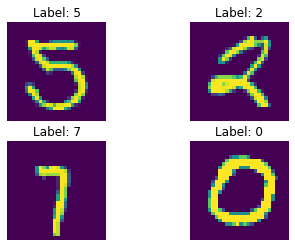

In [60]:
fig, ax = plt.subplots(2, 2);
ax[0, 0].imshow(images[284, ..., 0]);
ax[0, 0].set_title("Label: " + labels[284]);
ax[0, 0].axis("off");
ax[0, 1].imshow(images[1129, ..., 0]);
ax[0, 1].set_title("Label: " + labels[1129]);
ax[0, 1].axis("off");
ax[1, 0].imshow(images[9470, ..., 0]);
ax[1, 0].set_title("Label: " + labels[9470]);
ax[1, 0].axis("off");
ax[1, 1].imshow(images[30044, ..., 0]);
ax[1, 1].set_title("Label: " + labels[30044]);
ax[1, 1].axis("off");
plt.show()